## Hcondever variable and frailty index

#### Gavin Qu, May 30th

#### Extract the hcond and disdif data, and handle missing values

In [20]:
import pandas as pd
import numpy as np
import os

# Base directory containing the data files
base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'

# Health condition variables for different waves
base_hcond_variables = ['hcond1', 'hcond2', 'hcond3', 'hcond4', 'hcond5', 'hcond6', 'hcond7', 'hcond8', 'hcond9', 'hcond10', 'hcond11', 'hcond12', 'hcond13', 'hcond14', 'hcond15', 'hcond16']
hcondn_variables = ['hcondn1', 'hcondn2', 'hcondn3', 'hcondn4', 'hcondn5', 'hcondn6', 'hcondn7', 'hcondn8', 'hcondn9', 'hcondn10', 'hcondn11', 'hcondn12', 'hcondn13', 'hcondn14', 'hcondn15', 'hcondn16']
hcondever_variables = ['hcondever1', 'hcondever2', 'hcondever3', 'hcondever4', 'hcondever5', 'hcondever6', 'hcondever7', 'hcondever8', 'hcondever9', 'hcondever10', 'hcondever11', 'hcondever12', 'hcondever13', 'hcondever14', 'hcondever15', 'hcondever16']
hcondnew_variables = ['hcondnew1', 'hcondnew2', 'hcondnew3', 'hcondnew4', 'hcondnew5', 'hcondnew6', 'hcondnew7', 'hcondnew8', 'hcondnew10', 'hcondnew11', 'hcondnew12', 'hcondnew13', 'hcondnew14', 'hcondnew15', 'hcondnew16']
disdif_variables = ['disdif1', 'disdif2', 'disdif3', 'disdif4', 'disdif5', 'disdif6', 'disdif7', 'disdif8', 'disdif9', 'disdif10', 'disdif11']

# Prefixes for wave variables
prefixes = list('abcdefghijklm')

# Function to load data for a single wave
def load_wave_data(prefix, variables):
    file_path = os.path.join(base_dir, f'{prefix}_indresp.dta')
    df = pd.read_stata(file_path, convert_categoricals=False)
    # Include only columns that exist in the DataFrame
    available_vars = [var for var in [f'{prefix}_{var}' for var in variables] if var in df.columns]
    required_vars = ['pidp'] + available_vars
    df = df[required_vars]
    # Rename columns to remove the prefix for consistency
    df.columns = ['pidp'] + [var.split('_', 1)[1] for var in available_vars]
    return df

# Dictionary to store the variables per wave
variables_per_wave = {
    'a': base_hcond_variables + disdif_variables,
    'b': disdif_variables + hcondn_variables,
    'c': hcondn_variables + disdif_variables,
    'd': hcondn_variables + disdif_variables,
    'e': hcondn_variables + disdif_variables,
    'f': hcondn_variables + disdif_variables,
    'g': hcondn_variables + disdif_variables,
    'h': hcondn_variables + disdif_variables,
    'i': hcondn_variables + disdif_variables,
    'j': hcondever_variables + disdif_variables,
    'k': hcondnew_variables + disdif_variables,
    'l': hcondnew_variables + disdif_variables,
    'm': hcondnew_variables + disdif_variables
}

# Load data for all waves
data_frames = []

for prefix in prefixes:
    variables = variables_per_wave[prefix]
    df = load_wave_data(prefix, variables)
    data_frames.append(df)

# Concatenate all data frames
df_all = pd.concat(data_frames, ignore_index=True)

# Replace negative values with NaN
df_all.replace({-1: np.nan, -2: np.nan, -3: np.nan, -4: np.nan, -5: np.nan, -6: np.nan, -7: np.nan, -8: np.nan, -9: np.nan}, inplace=True)

# Save combined DataFrame to a new CSV file without modifying NaN values
df_all.to_csv("combined_UKHLS_data.csv", index=False)


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_51897/1929198859.py:21: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata(file_path, convert_categoricals=False)
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_51897/1929198859.py:21: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata(file_path, convert_categoricals=False)


### Constructing {prefix}_healthcond1-16 Variables

In [25]:
import pandas as pd
import numpy as np

# Load the combined data with the correct path
df_all = pd.read_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/combined_UKHLS_data.csv")

# List of health condition variables and prefixes
health_cond_vars = ['hcond1', 'hcond2', 'hcond3', 'hcond4', 'hcond5', 'hcond6', 'hcond7', 'hcond8', 'hcond9', 'hcond10', 'hcond11', 'hcond12', 'hcond13', 'hcond14', 'hcond15', 'hcond16']
prefixes = list('abcdefghijklm')

# Initialize the health condition tracking variables
for i in range(1, 17):
    for prefix in prefixes:
        df_all[f'{prefix}_healthcond{i}'] = np.nan

# Function to update the health condition tracking variables using vectorized operations
def update_healthcond_tracking(df):
    for i in range(1, 17):
        var = f'healthcond{i}'
        
        # Wave 'a' (hcond: all participants)
        if f'hcond{i}' in df.columns:
            df[f'a_{var}'] = df[f'hcond{i}']
        
        # Waves 'b' to 'i' (hcond and hcondn: new entrants only)
        for wave in 'bcdefghi':
            hcond_col = f'hcond{i}'
            hcondn_col = f'hcondn{i}'
            if hcond_col in df.columns and hcondn_col in df.columns:
                df[f'{wave}_{var}'] = df[hcond_col].where(df[hcond_col] >= 0, np.nan).combine_first(df[hcondn_col])
            elif hcond_col in df.columns:
                df[f'{wave}_{var}'] = df[hcond_col].where(df[hcond_col] >= 0, np.nan)
            elif hcondn_col in df.columns:
                df[f'{wave}_{var}'] = df[hcondn_col]
        
        # Wave 'j' (hcondever: all participants)
        hcondever_col = f'hcondever{i}'
        if hcondever_col in df.columns:
            df[f'j_{var}'] = df[hcondever_col]
        
        # Waves 'k' to 'm' (hcond and hcondnew: new entrants only)
        for wave in 'klm':
            hcond_col = f'hcond{i}'
            hcondnew_col = f'hcondnew{i}'
            if hcond_col in df.columns and hcondnew_col in df.columns:
                df[f'{wave}_{var}'] = df[hcond_col].where(df[hcond_col] >= 0, np.nan).combine_first(df[hcondnew_col])
            elif hcond_col in df.columns:
                df[f'{wave}_{var}'] = df[hcond_col].where(df[hcond_col] >= 0, np.nan)
            elif hcondnew_col in df.columns:
                df[f'{wave}_{var}'] = df[hcondnew_col]
        
        # Propagate values forward: if any previous wave is 1, it stays 1
        for wave in 'bcdefghijklm':
            prev_waves = [f'{w}_{var}' for w in prefixes[:prefixes.index(wave)]]
            df[f'{wave}_{var}'] = df[prev_waves + [f'{wave}_{var}']].max(axis=1, skipna=True)
    
    return df

# Update the health condition tracking variables
df_all = update_healthcond_tracking(df_all)

# Save the updated DataFrame to a new CSV file
df_all.to_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_data.csv", index=False)


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_51897/1084143746.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[f'{prefix}_healthcond{i}'] = np.nan
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_51897/1084143746.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[f'{prefix}_healthcond{i}'] = np.nan
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_51897/1084143746.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

#### Count the values of healthcond when they are 1, 0 and missing. 

In [27]:
import pandas as pd

# Load the updated data
df_all = pd.read_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_data.csv")

# List of health condition tracking variables and prefixes
health_cond_vars = [f'healthcond{str(i)}' for i in range(1, 17)]
prefixes = list('abcdefghijklm')

# Initialize a dictionary to store the counts
counts = {
    'variable': [],
    'count_1': [],
    'count_0': [],
    'count_missing': []
}

# Function to count the values of health condition tracking variables
def count_healthcond_values(df, health_cond_vars, prefixes):
    for var in health_cond_vars:
        for prefix in prefixes:
            healthcond_var = f'{prefix}_{var}'
            if healthcond_var in df.columns:
                counts['variable'].append(healthcond_var)
                counts['count_1'].append((df[healthcond_var] == 1).sum())
                counts['count_0'].append((df[healthcond_var] == 0).sum())
                counts['count_missing'].append(df[healthcond_var].isna().sum())
    return counts

# Count the values of health condition tracking variables
counts = count_healthcond_values(df_all, health_cond_vars, prefixes)

# Create a DataFrame from the counts dictionary
counts_df = pd.DataFrame(counts)

# Display the counts DataFrame
print(counts_df)

# Save the counts DataFrame to a CSV file
counts_df.to_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/healthcond_counts.csv", index=False)


           variable  count_1  count_0  count_missing
0     a_healthcond1     6269    41336         485871
1     b_healthcond1     9912   349575         169374
2     c_healthcond1     9912   349575         169374
3     d_healthcond1     9912   349575         169374
4     e_healthcond1     9912   349575         169374
..              ...      ...      ...            ...
203  i_healthcond16    18403   341236         169222
204  j_healthcond16    23938   368036         136887
205  k_healthcond16    27188   450276          51397
206  l_healthcond16    27188   450276          51397
207  m_healthcond16    27188   450276          51397

[208 rows x 4 columns]


### Add age and death data

In [31]:
import pandas as pd
import os

# Base directory containing the data
base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'

# Load the combined data
df_all = pd.read_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_data.csv")

# Load the death data from xwavedat.dta
xwave_df = pd.read_stata(os.path.join(base_dir, 'xwavedat.dta'))

# Mapping wave number to death value
death_mapping = {
    'UKHLS Wave 20': 'b', 'UKHLS Wave 21': 'c', 'UKHLS Wave 22': 'd', 'UKHLS Wave 23': 'e', 
    'UKHLS Wave 24': 'f', 'UKHLS Wave 25': 'g', 'UKHLS Wave 26': 'h', 'UKHLS Wave 27': 'i', 
    'UKHLS Wave 28': 'j', 'UKHLS Wave 29': 'k', 'UKHLS Wave 30': 'l', 'UKHLS Wave 31': 'm'
}

# Merge death data to df_all
df_all = df_all.merge(xwave_df[['pidp', 'dcsedw_dv']], on='pidp', how='left')

# Load age_dv data for each wave and merge with df_all
def load_and_merge_age_data(df, base_dir, prefixes):
    for prefix in prefixes:
        file_path = os.path.join(base_dir, f'{prefix}_indresp.dta')
        if os.path.exists(file_path):
            wave_df = pd.read_stata(file_path, columns=['pidp', f'{prefix}_age_dv'])
            df = df.merge(wave_df, on='pidp', how='left')
    return df

# Add age variable for each wave
prefixes = list('abcdefghijklm')
df_all = load_and_merge_age_data(df_all, base_dir, prefixes)

# Function to mark death in the relevant waves
def mark_death(df, death_mapping):
    for wave, wave_prefix in death_mapping.items():
        df[f'{wave_prefix}_death'] = df['dcsedw_dv'].apply(lambda x: 1 if x == wave else 0)
    return df

# Mark death in the relevant waves
df_all = mark_death(df_all, death_mapping)

# Save the updated DataFrame to a new CSV file
df_all.to_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_age_and_death.csv", index=False)


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_51897/308859658.py:28: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  wave_df = pd.read_stata(file_path, columns=['pidp', f'{prefix}_age_dv'])
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_51897/308859658.py:28: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  wave_df = pd.read_stata(file_path, columns=['pidp', f'{prefix}_age_dv'])


####  Check Death Count and Valid Age Data

In [32]:
import pandas as pd

# Load the updated data
df_all = pd.read_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_age_and_death.csv")

# Function to calculate death count and check valid age data for each wave
def check_death_count_and_age_data(df, prefixes):
    death_counts = {}
    age_validity = {}

    for prefix in prefixes:
        death_var = f'{prefix}_death'
        age_var = f'{prefix}_age_dv'
        
        if death_var in df.columns:
            death_counts[prefix] = df[death_var].sum()
        
        if age_var in df.columns:
            valid_age_count = df[age_var].notna().sum()
            total_count = df[age_var].shape[0]
            age_validity[prefix] = f'{valid_age_count} out of {total_count} have valid age data'

    return death_counts, age_validity

# Define prefixes
prefixes = list('abcdefghijklm')

# Check death count and age data validity
death_counts, age_validity = check_death_count_and_age_data(df_all, prefixes)

# Print the results
print("Death Counts for Each Wave:")
for prefix, count in death_counts.items():
    print(f"Wave {prefix.upper()}: {count}")

print("\nAge Data Validity for Each Wave:")
for prefix, validity in age_validity.items():
    print(f"Wave {prefix.upper()}: {validity}")


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_51897/2766674067.py:4: DtypeWarning: Columns (284,285,288,289,291,292,293,294,295) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_age_and_death.csv")


Death Counts for Each Wave:
Wave B: 233
Wave C: 564
Wave D: 957
Wave E: 1090
Wave F: 1438
Wave G: 1971
Wave H: 2379
Wave I: 2357
Wave J: 2605
Wave K: 2745
Wave L: 2902
Wave M: 3225

Age Data Validity for Each Wave:
Wave A: 337477 out of 533476 have valid age data
Wave B: 423039 out of 533476 have valid age data
Wave C: 421983 out of 533476 have valid age data
Wave D: 422124 out of 533476 have valid age data
Wave E: 416114 out of 533476 have valid age data
Wave F: 414007 out of 533476 have valid age data
Wave G: 404375 out of 533476 have valid age data
Wave H: 390028 out of 533476 have valid age data
Wave I: 369078 out of 533476 have valid age data
Wave J: 355787 out of 533476 have valid age data
Wave K: 335468 out of 533476 have valid age data
Wave L: 309260 out of 533476 have valid age data
Wave M: 292212 out of 533476 have valid age data


### Frailty index with death counted as 1 using the healthcond and disdiff variables

In [3]:
import pandas as pd
import numpy as np

# Define the base directory and file paths
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_age_and_death.csv"
output_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"

# Define the health condition and difficulty with daily task variables
health_cond_vars = [f'healthcond{i}' for i in range(1, 17)]
disdif_vars = [f'disdif{i}' for i in range(1, 12)]
prefixes = list('abcdefghijklm')

# Function to compute frailty index for each wave
def compute_frailty_index(df, prefixes):
    for prefix in prefixes:
        health_vars = [f'{prefix}_{var}' for var in health_cond_vars]
        disdif_vars = [f'{prefix}_disdif{i}' for i in range(1, 12)]
        all_vars = health_vars + disdif_vars
        
        # Ensure all necessary columns are present
        present_vars = [var for var in all_vars if var in df.columns]

        # Compute the frailty index
        def calculate_frailty(row):
            if prefix != 'a' and row.get(f'{prefix}_death') == 1:
                return 1.0
            values = row[present_vars]
            # Only count as missing if all are NaN or negative
            if all(v < 0 or pd.isna(v) for v in values):
                return np.nan
            # Calculate frailty score excluding NaNs and negatives
            valid_values = values[(values >= 0) & ~values.isna()]
            frailty_score = valid_values.sum() / 27
            return frailty_score

        df[f'{prefix}_frailty'] = df.apply(calculate_frailty, axis=1)
    
    # Propagate death frailty to subsequent waves
    death_indices = {}
    for i, prefix in enumerate(prefixes):
        if prefix != 'a':  # skip wave 'a' for death check
            death_indices[prefix] = df[df[f'{prefix}_death'] == 1].index

    for prefix in prefixes:
        start_index = prefixes.index(prefix) + 1
        for next_prefix in prefixes[start_index:]:
            if prefix in death_indices:
                df.loc[death_indices[prefix], f'{next_prefix}_frailty'] = 1.0

    return df

# Process the data in chunks to manage memory usage effectively
chunk_size = 5000  # Adjust chunk size based on memory availability
first_chunk = True

for df_chunk in pd.read_csv(data_file, chunksize=chunk_size, low_memory=False):
    df_chunk = compute_frailty_index(df_chunk, prefixes)
    if first_chunk:
        df_chunk.to_csv(output_file, index=False, mode='w', header=True)
        first_chunk = False
    else:
        df_chunk.to_csv(output_file, index=False, mode='a', header=False)


### Total count of frailty by wave

In [7]:
import pandas as pd

# Path to the file containing frailty data
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"

# Read the data
df = pd.read_csv(data_file)

# List of waves
prefixes = list('abcdefghijklm')

# Checking for duplicates for each wave based on 'pidp'
for prefix in prefixes:
    pidp_col = f'{prefix}_pidp'  # assuming pidp is named like 'a_pidp', 'b_pidp', etc.
    if pidp_col in df.columns:
        initial_count = df[pidp_col].count()
        df.drop_duplicates(subset=[pidp_col], inplace=True)
        final_count = df[pidp_col].count()
        if initial_count != final_count:
            print(f"Duplicate entries found and removed in wave {prefix.upper()}.")

# Initialize a dictionary to store the results
frailty_stats = {}

# Compute statistics for each wave
for prefix in prefixes:
    frailty_var = f'{prefix}_frailty'
    if frailty_var in df.columns:
        # Calculate counts for different frailty conditions
        zero_frailty = (df[frailty_var] == 0).sum()
        positive_frailty = ((df[frailty_var] > 0) & (df[frailty_var] < 1)).sum()
        missing_frailty = df[frailty_var].isna().sum()
        one_frailty = (df[frailty_var] == 1).sum()

        # Store the counts in the dictionary
        frailty_stats[prefix] = {
            'Zero Frailty': zero_frailty,
            'Positive Frailty': positive_frailty,
            'Missing Frailty': missing_frailty,
            'Frailty == 1': one_frailty
        }

# Output the results
print("Frailty Counts for Each Wave:")
for prefix, stats in frailty_stats.items():
    print(f"Wave {prefix.upper()}:")
    for condition, count in stats.items():
        print(f"  {condition}: {count}")
    print()



/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/3760021513.py:7: DtypeWarning: Columns (284,285,288,289,291,292,293,294,295) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


Frailty Counts for Each Wave:
Wave A:
  Zero Frailty: 26593
  Positive Frailty: 21012
  Missing Frailty: 485871
  Frailty == 1: 0

Wave B:
  Zero Frailty: 307483
  Positive Frailty: 51949
  Missing Frailty: 173811
  Frailty == 1: 233

Wave C:
  Zero Frailty: 307275
  Positive Frailty: 51661
  Missing Frailty: 173743
  Frailty == 1: 797

Wave D:
  Zero Frailty: 306824
  Positive Frailty: 51256
  Missing Frailty: 173642
  Frailty == 1: 1754

Wave E:
  Zero Frailty: 306249
  Positive Frailty: 50881
  Missing Frailty: 173502
  Frailty == 1: 2844

Wave F:
  Zero Frailty: 305367
  Positive Frailty: 50475
  Missing Frailty: 173352
  Frailty == 1: 4282

Wave G:
  Zero Frailty: 304217
  Positive Frailty: 49902
  Missing Frailty: 173104
  Frailty == 1: 6253

Wave H:
  Zero Frailty: 302683
  Positive Frailty: 49274
  Missing Frailty: 172887
  Frailty == 1: 8632

Wave I:
  Zero Frailty: 301114
  Positive Frailty: 48705
  Missing Frailty: 172668
  Frailty == 1: 10989

Wave J:
  Zero Frailty: 317687

### Smoothed Line Plot of Frailty against Age 

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the frailty index data
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'
frailty_data = pd.read_stata(frailty_index_path)

# Load the cleaned combined data to get the age variables
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
combined_data = pd.read_stata(cleaned_combined_data_path)

# Define wave prefixes and age column prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]
age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]

# Prepare data for the smoothed line plot
scatter_data = pd.DataFrame()

for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    age_col = f'{prefix}_age_dv'
    if frailty_col in frailty_data.columns and age_col in combined_data.columns:
        temp_df = frailty_data[['pidp', frailty_col]].copy()
        temp_age_df = combined_data[['pidp', age_col]].copy()
        temp_df = temp_df.merge(temp_age_df, on='pidp')
        temp_df = temp_df[temp_df[frailty_col] > 0]  # Filter out zero frailty index values
        temp_df['wave'] = prefix
        temp_df = temp_df.rename(columns={frailty_col: 'frailty_index', age_col: 'age'})
        scatter_data = pd.concat([scatter_data, temp_df], ignore_index=True)

# Create smoothed line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd')
plt.xlabel('Age')
plt.ylabel('Frailty Index')
plt.title('Smoothed Line Plot: Frailty Index vs Age Across Waves')
plt.grid(True)
plt.show()

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/2671498213.py:7: DtypeWarning: Columns (284,285,288,289,291,292,293,294,295) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


TypeError: '>=' not supported between instances of 'str' and 'int'

### Smooth line plot but including frailty == 0

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_50045/2038237390.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd')


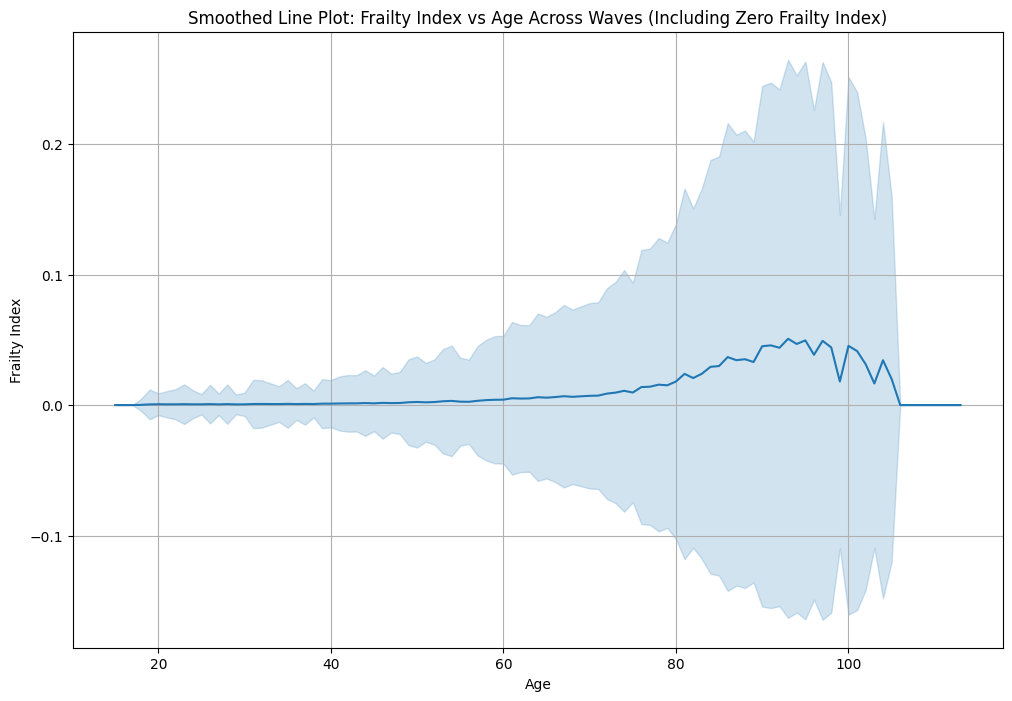

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the frailty index data
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'
frailty_data = pd.read_stata(frailty_index_path)

# Load the cleaned combined data to get the age variables
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
combined_data = pd.read_stata(cleaned_combined_data_path)

# Define wave prefixes and age column prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]
age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]

# Prepare data for the smoothed line plot
scatter_data = pd.DataFrame()

for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    age_col = f'{prefix}_age_dv'
    if frailty_col in frailty_data.columns and age_col in combined_data.columns:
        temp_df = frailty_data[['pidp', frailty_col]].copy()
        temp_age_df = combined_data[['pidp', age_col]].copy()
        temp_df = temp_df.merge(temp_age_df, on='pidp')
        temp_df = temp_df[temp_df[frailty_col] >= 0]  # Filter out negative frailty index values
        temp_df['wave'] = prefix
        temp_df = temp_df.rename(columns={frailty_col: 'frailty_index', age_col: 'age'})
        scatter_data = pd.concat([scatter_data, temp_df], ignore_index=True)

# Create smoothed line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd')
plt.xlabel('Age')
plt.ylabel('Frailty Index')
plt.title('Smoothed Line Plot: Frailty Index vs Age Across Waves (Including Zero Frailty Index)')
plt.grid(True)
plt.show()


### Test for the decline in non-zero frailty values and positive values in disdif

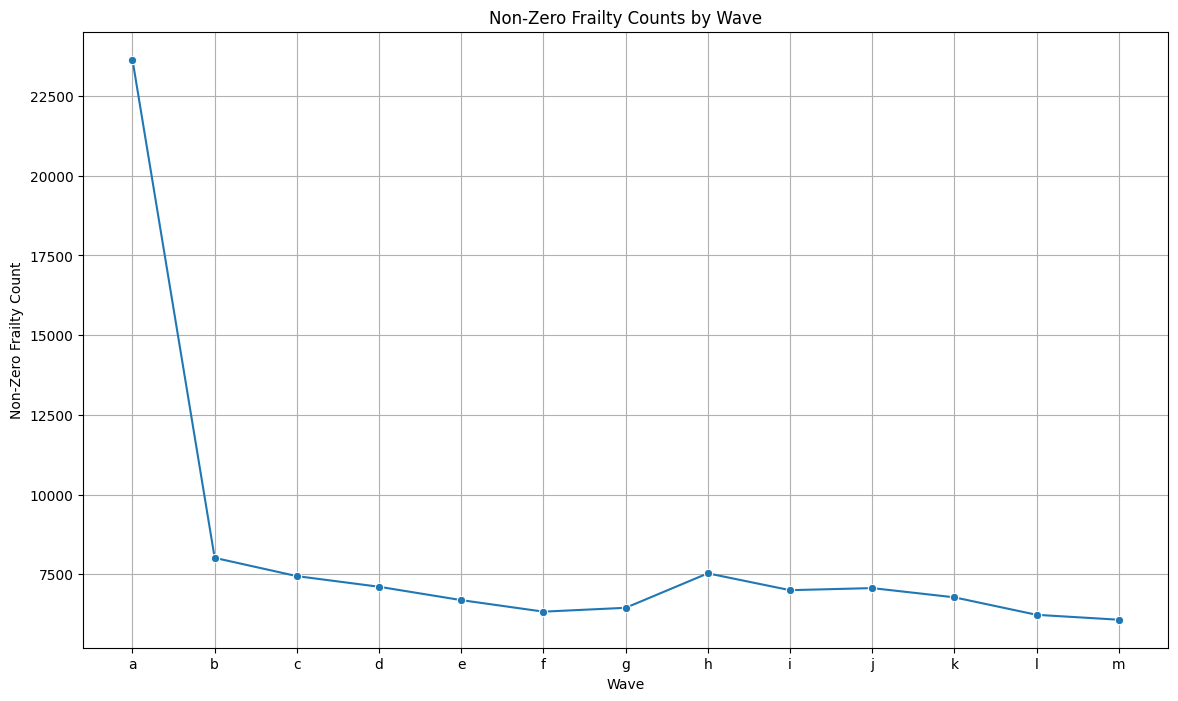

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the frailty index data
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'
frailty_data = pd.read_stata(frailty_index_path)

# Define wave prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Initialize dictionary to store counts
frailty_counts = {
    'Wave': [],
    'Non-Zero Frailty Count': []
}

# Calculate the non-zero frailty counts for each wave
for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    
    if frailty_col in frailty_data.columns:
        non_zero_frailty_count = (frailty_data[frailty_col] > 0).sum()
        
        frailty_counts['Wave'].append(prefix)
        frailty_counts['Non-Zero Frailty Count'].append(non_zero_frailty_count)

# Convert dictionary to DataFrame
frailty_counts_df = pd.DataFrame(frailty_counts)

# Plot the non-zero frailty counts by wave
plt.figure(figsize=(14, 8))
sns.lineplot(data=frailty_counts_df, x='Wave', y='Non-Zero Frailty Count', marker='o')
plt.xlabel('Wave')
plt.ylabel('Non-Zero Frailty Count')
plt.title('Non-Zero Frailty Counts by Wave')
plt.grid(True)
plt.show()


### Plot of disdif by non-unique pidp

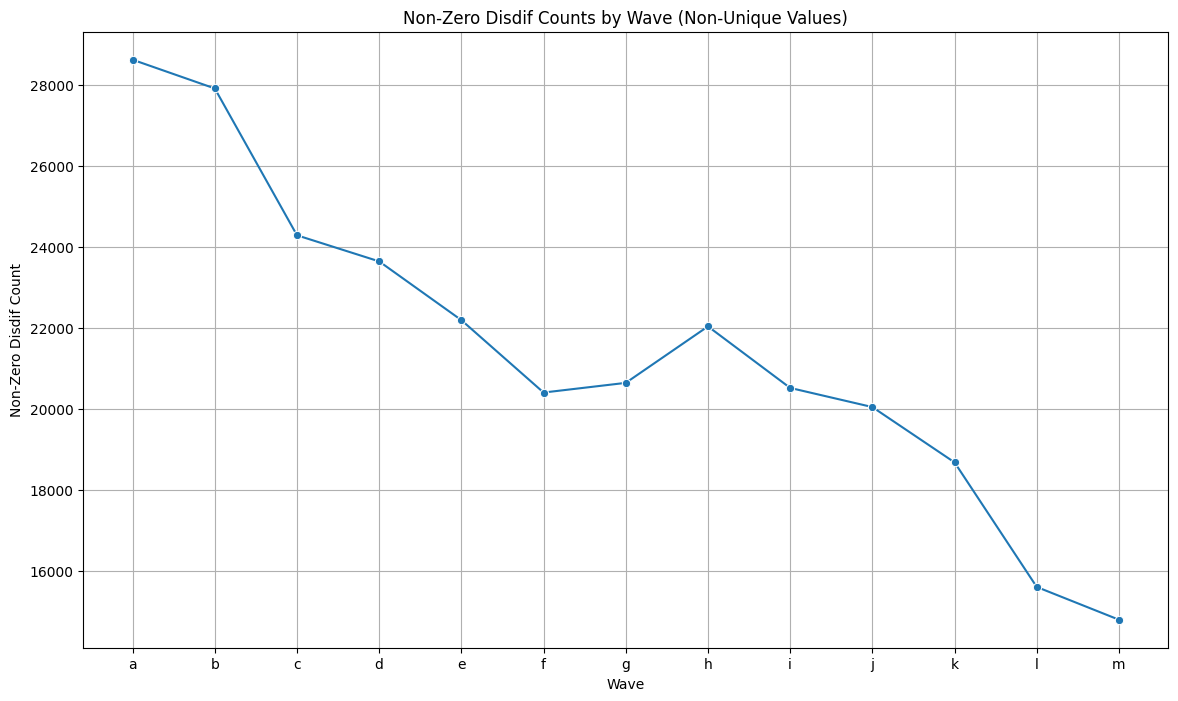

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned combined data
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
cleaned_combined_data = pd.read_stata(cleaned_combined_data_path)

# Define wave prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Initialize dictionary to store non-zero counts
non_zero_disdif_counts = {
    'Wave': [],
    'Non-Zero Disdif': []
}

# Calculate non-zero counts for each wave
for prefix in wave_prefixes:
    disdif_cols = [f'{prefix}_disdif{i}' for i in range(1, 12)]
    
    if any(col in cleaned_combined_data.columns for col in disdif_cols):
        non_zero_disdif_counts['Wave'].append(prefix)
        
        # Count non-zero, non-negative values
        non_zero_disdif = ((cleaned_combined_data[disdif_cols] > 0) & (cleaned_combined_data[disdif_cols] >= 0)).sum().sum()
        
        non_zero_disdif_counts['Non-Zero Disdif'].append(non_zero_disdif)

# Convert dictionary to DataFrame
non_zero_disdif_counts_df = pd.DataFrame(non_zero_disdif_counts)

# Plot the non-zero counts for disdif by wave
plt.figure(figsize=(14, 8))
sns.lineplot(data=non_zero_disdif_counts_df, x='Wave', y='Non-Zero Disdif', marker='o')
plt.xlabel('Wave')
plt.ylabel('Non-Zero Disdif Count')
plt.title('Non-Zero Disdif Counts by Wave (Non-Unique Values)')
plt.grid(True)
plt.show()
